In [52]:
import numpy as np
np.set_printoptions(precision=4)
from scipy.stats import norm, multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib as mpl
import infomeasure as im
from sortedcontainers import SortedList


mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [53]:
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)

In [54]:
""" This seems to be the best metric for now"""
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)

def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [55]:
# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-4)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt

In [56]:
# Parameters
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
T = 100001
dt = 1/T            
v_max = .2 * dt_emp * T 
d = 2                
n_dirs = 2000

# Projection directions (unit vectors on S^1)
#angles = np.random.uniform(0, 2 * np.pi, size=n_dirs)
angles = np.linspace(0, 2 * np.pi, n_dirs)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  

# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = np.array([.5,.5])#np.random.uniform(low=0.0, high=1.0, size=(2,))

Advantages: Algorithmn is more versatile, works finde for different speeds, increasing velocities, or rather larger delta ts computations!
No issues with periodicity, are basis outside of the domain
Higher accuracy as speed increases!

i.e works better on coarser grid major bottle kneck approximation of cdf!

In [ ]:
divergence = []
sls = [SortedList() for _ in range(n_dirs)]
proj = np.zeros((T, n_dirs))
for i in range(1, T):
    if i % 10000 == 0 and i != 1:
        print(f"Step {i}/{T}")
        mu_samples = mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples = f[:i,:].shape[0])
        KL = im.kld(f[:i,:],mu_samples, approach='metric')
        divergence.append(KL)
        print(KL, 'emp')
    # Model-based PDF, CDF, projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i - 1], means, covs, weights)
    proj[i - 1] = proj_xt
    # SortedList method
    F_push = np.empty(n_dirs, dtype=float)
    for j in range(n_dirs):
        cnt_prev = sls[j].bisect_right(proj_xt[j])
        F_push[j] = (cnt_prev + 1) / i
        sls[j].add(proj_xt[j])
        
    deltas = F_push - cdfs
    pdfs = np.maximum(pdfs, 1e-6)
    grad = 1.5 * (deltas / (2 * pdfs * dt)) - 1 / (2 * pdfs) + (np.sign(deltas) / (2 * pdfs))
    grad = grad @ dirs
    grad /= np.linalg.norm(grad)
    f[i] = f[i - 1] + v_max * dt * grad

Step 10000/100001
1.5013662270184889 emp
Step 20000/100001
0.9462923054173564 emp
Step 30000/100001
0.7571240032487667 emp
Step 40000/100001
0.588649138722779 emp
Step 50000/100001
0.47368386113426797 emp
Step 60000/100001
0.39191052442898866 emp


In [ ]:
np.save(rf"Divergence_Data/Sliced_{n_dirs}.npy", np.array(divergence))

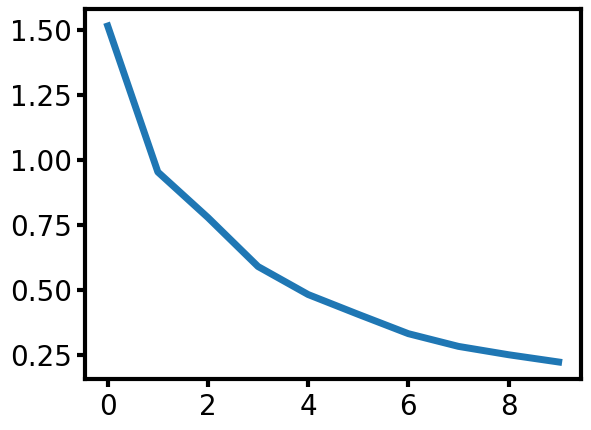

In [ ]:
plt.plot(divergence)

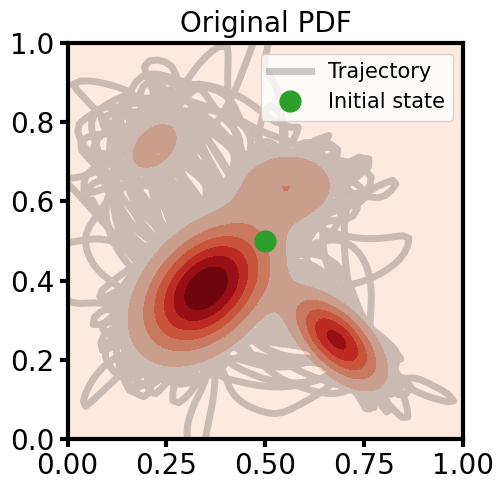

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,0], f[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0], f[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

2025-08-20 09:03:24,969 |  WARNING | legend.py:1323 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


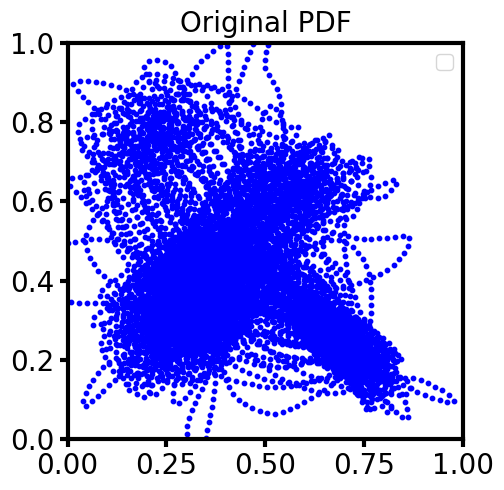

In [ ]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(f[::10, 0], f[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [ ]:
import infomeasure as im
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
mu_samples_test = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
print(im.kld(f,mu_samples, approach='metric'), 'emp')
print(im.kld(mu_samples_test, mu_samples, approach='metric'), 'opt')

NameError: name 'sample_from_density_2d' is not defined

In [ ]:
"""dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
T = 100000
dt = 1/T            
v_max = .2 * dt_emp * T 
d = 2                
n_dirs = 200
# Projection directions (unit vectors on S^1)
#angles = np.random.uniform(0, 2 * np.pi, size=n_dirs)
angles = np.linspace(0, 2 * np.pi, n_dirs)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  
N = 1                # number of agents
f = np.zeros((T, 2, N))

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    K = dirs.shape[0]
    M = means.shape[0]
    proj_xt = dirs @ xt            # (K, N)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)
    proj_stds = np.sqrt(proj_vars + 1e-8)
    
    # Compute PDF and CDF for each component at proj_xt
    # proj_xt: (K,N) -> expand to (M,K,N)
    proj_xt_expand = proj_xt[None, :, :]  # (1,K,N)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means[:, :, None], scale=proj_stds[:, :, None])  # (M,K,N)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means[:, :, None], scale=proj_stds[:, :, None])  # (M,K,N)
    
    weighted_pdfs = (weights[:, None, None] * pdfs).sum(axis=0)  # (K,N)
    weighted_cdfs = (weights[:, None, None] * cdfs).sum(axis=0)  # (K,N)
    
    return weighted_pdfs, weighted_cdfs, proj_xt  # all shape (K,N)

# --- Initialize SortedLists per direction ---
sls = [SortedList() for _ in range(n_dirs)]

divergence = []

for i in range(1, T):
    if i % 10000 == 0:
        print(f"Step {i}/{T}")
    
    # Get current positions
    xt = f[i-1]  # shape (2,N)
    
    # Model-based PDF, CDF, projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, xt, means, covs, weights)  # shapes (K,N)
    
    # --- SortedList / empirical CDF per agent ---
    F_push = np.zeros_like(proj_xt)  # (K,N)
    for j in range(n_dirs):
        for n in range(N):
            # count previous projections ≤ current agent's projection
            cnt_prev = sls[j].bisect_right(proj_xt[j,n])
            F_push[j,n] = (cnt_prev + 1) / i
            sls[j].add(proj_xt[j,n])
    
    # --- Compute update ---
    deltas = F_push - cdfs  # (K,N)
    pdfs = np.maximum(pdfs, 1e-6)
    
    grad = 1.5 * (deltas / (2*pdfs*dt)) - 1/(2*pdfs) + (np.sign(deltas)/(2*pdfs))
    grad = grad.T @ dirs      # shape (N,2)
    
    # Normalize per agent
    grad /= (np.linalg.norm(grad, axis=1, keepdims=True) + 1e-8)
    
    # Euler step
    f[i] = f[i-1] + v_max * dt * grad.T
"""

'dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T\nT = 100000\ndt = 1/T            \nv_max = .2 * dt_emp * T \nd = 2                \nn_dirs = 200\n# Projection directions (unit vectors on S^1)\n#angles = np.random.uniform(0, 2 * np.pi, size=n_dirs)\nangles = np.linspace(0, 2 * np.pi, n_dirs)\ndirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  \nN = 1                # number of agents\nf = np.zeros((T, 2, N))\n\ndef projected_pdf_cdf_mog(dirs, xt, means, covs, weights):\n    K = dirs.shape[0]\n    M = means.shape[0]\n    proj_xt = dirs @ xt            # (K, N)\n    \n    # Project means: (M, K)\n    proj_means = means @ dirs.T    # (M, K)\n    \n    # Project variances\n    proj_vars = np.zeros((M, K))\n    for m in range(M):\n        Sigma_m = covs[m]\n        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)\n    proj_stds = np.sqrt(proj_vars + 1e-8)\n    \n    # Compute PDF and CDF for each component at proj_xt\n    # proj_xt: (K,N) -> expan

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

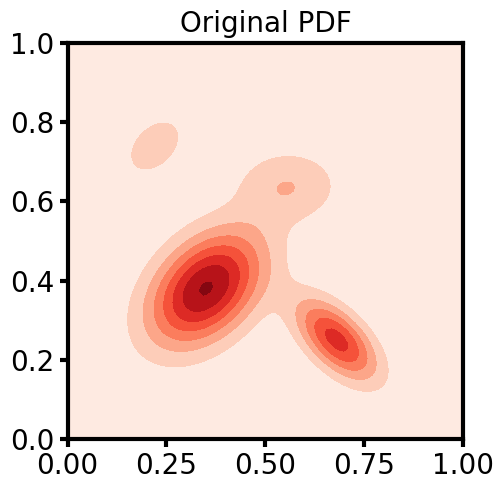

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,1,0], f[::10,1,0], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0,1], f[0,1,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)
plt.show()
plt.close()
